In [1]:
%autosave 1

Autosaving every 1 seconds


# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


## 4.1 Evaluation metrics: session overview 

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import urllib.request

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"  # replace with your actual $data link
urllib.request.urlretrieve(url, "data/data-week-3.csv")

('data/data-week-3.csv', <http.client.HTTPMessage at 0x15f08193da0>)

In [6]:
df = pd.read_csv('data/data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

# df.churn == 'yes' this type crease True or False. True when 'yes'. .astype(int) converts each Boolean value into an integer: True - 1, False - 0
df.churn = (df.churn == 'yes').astype(int)

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [8]:
numerical = list(
    df_full_train.columns[
    df_full_train.dtypes != 'object']
)
display(numerical)

numerical.remove('seniorcitizen')
numerical.remove('churn')
numerical

['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges', 'churn']

['tenure', 'monthlycharges', 'totalcharges']

In [9]:
categorical = list(
    df_full_train.columns[df_full_train.dtypes == 'object']
)
display(categorical)
categorical.remove('customerid')
categorical.append('seniorcitizen')
display(categorical)


['customerid',
 'gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod']

['gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'seniorcitizen']

In [10]:
# sparse=False - return a regular NumPy array instead of a sparse matrix. 
# When you one-hot encode categorical variables (like gender, country, etc.), you often create many columns full of zeros — e.g., for 1,000 countries, each observation might have 999 zeros and one 1.
# To save memory, scikit-learn usually stores such data in a sparse matrix, where only the non-zero entries are kept in memory.
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [11]:
# Check the column names that were generated
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [12]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean().round(3)

0.803

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [13]:
# Total number of `churned` people
len(y_val)

1409

In [14]:
# Total number of correct predictions regarding `churned` people
(y_val == churn_decision).sum()

1132

In [15]:
# Let's estimate the proportion of correct predictions
(y_val == churn_decision).mean()

0.8034066713981547

In [16]:
# Let's estimate the accuracy rate
1132/ 1409

0.8034066713981547

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [19]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


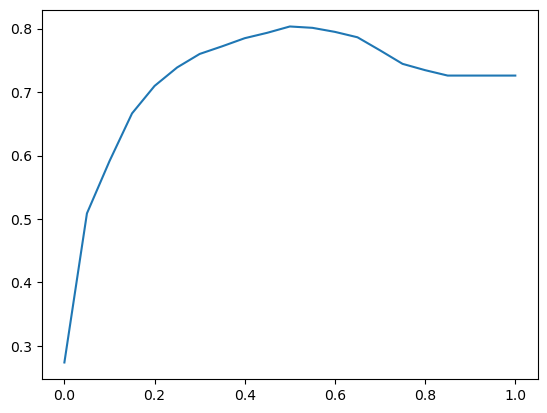

In [20]:
plt.plot(thresholds, scores)
plt.show()

In [21]:
from collections import Counter

In [22]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [23]:
1 - y_val.mean()

0.7260468417317246

## 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table

In [24]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

display(actual_positive, actual_negative)

array([False, False, False, ..., False,  True,  True])

array([ True,  True,  True, ...,  True, False, False])

In [25]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [26]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [27]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [28]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall

In [29]:
p = tp / (tp + fp)
p

0.6752411575562701

In [30]:
r = tp / (tp + fn)
r

0.5440414507772021

## 4.5 ROC Curves

### TPR and FRP

In [31]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [32]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [33]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
    
scores[: 10]    

[(0.0, 386, 1023, 0, 0),
 (0.01, 385, 913, 1, 110),
 (0.02, 384, 830, 2, 193),
 (0.03, 383, 766, 3, 257),
 (0.04, 381, 715, 5, 308),
 (0.05, 379, 685, 7, 338),
 (0.06, 377, 661, 9, 362),
 (0.07, 372, 641, 14, 382),
 (0.08, 371, 613, 15, 410),
 (0.09, 369, 580, 17, 443)]

In [34]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [35]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


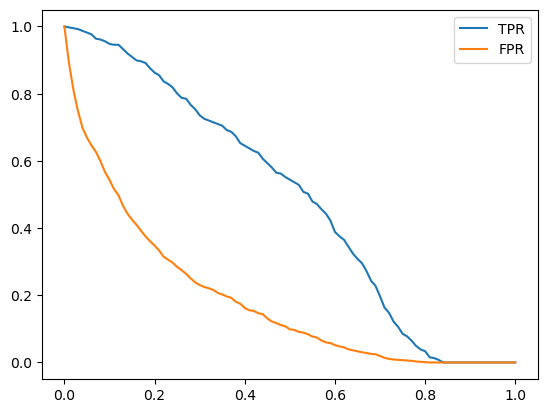

In [36]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend();

### Random model

In [37]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [38]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [39]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [40]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

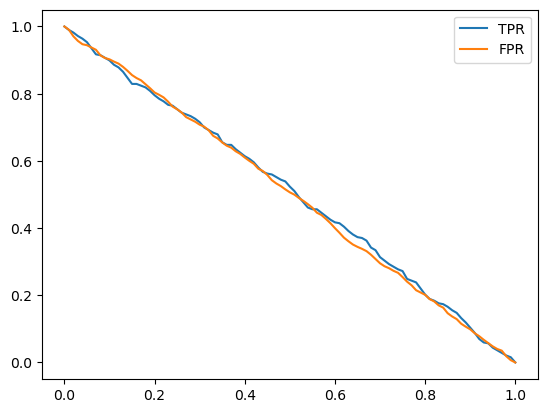

In [41]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend();

### Ideal model

In [42]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [43]:
# will repeat 0 `num_neg` number of times, and 1 `num_pos` number of times
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
display(y_ideal)

# Create predictions
y_ideal_pred = np.linspace(0, 1, len(y_val))

array([0, 0, 0, ..., 1, 1, 1])

In [44]:
# For people above 0.726 we are 100% correct in identifying churn rate. 0.726 comes from below.
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [45]:
1 - y_val.mean()

0.7260468417317246

In [46]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [47]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


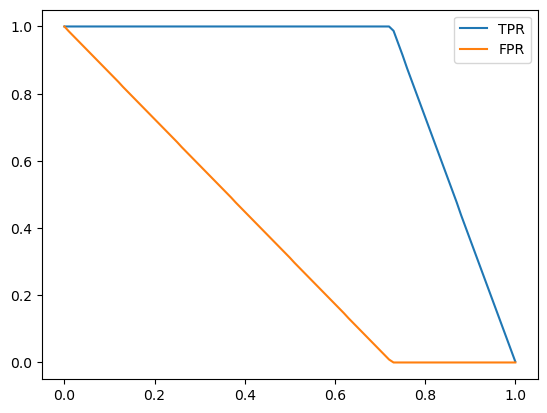

In [48]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend();

### Putting everything together

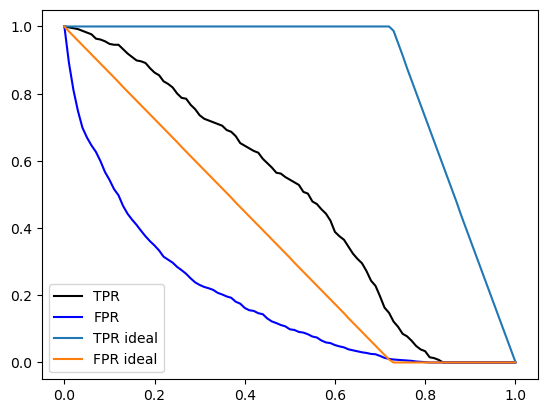

In [49]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend();

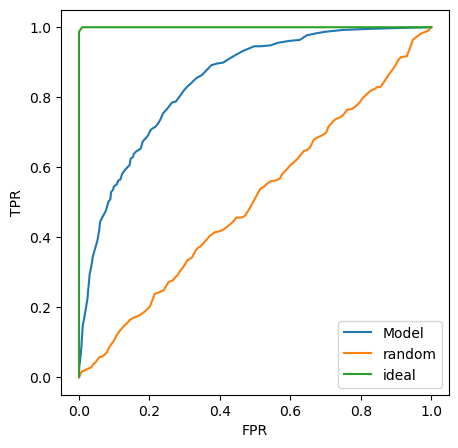

In [50]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend();

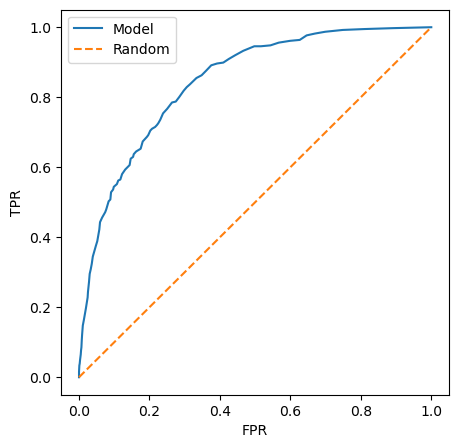

In [51]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend();

In [52]:
from sklearn.metrics import roc_curve

In [53]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

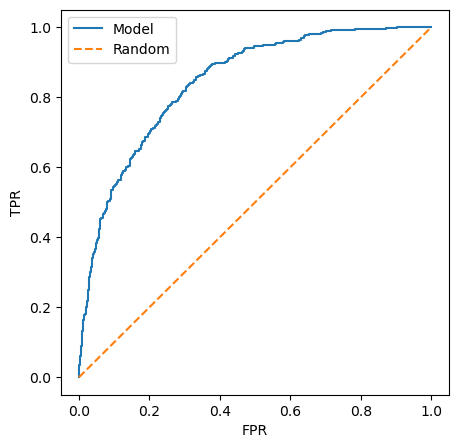

In [55]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend();

## 4.6 ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC

In [61]:
from sklearn.metrics import auc

In [62]:
auc(fpr, tpr)

0.8438302463039217

In [63]:
auc(df_scores.fpr, df_scores.tpr)

0.8438986218528255

In [64]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [65]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438302463039217

In [66]:
from sklearn.metrics import roc_auc_score

In [67]:
roc_auc_score(y_val, y_pred)

0.8438302463039217

In [68]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [69]:
neg

array([0.00899994, 0.2045765 , 0.21225399, ..., 0.10775343, 0.31386635,
       0.13642888])

In [72]:
import random

In [77]:
random.seed(2)
pos_ind = random.randint(0, len(pos) - 1)
neg_ind = random.randint(0, len(neg) - 1)

In [79]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84337

In [80]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84646

## 4.7 Cross-Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [82]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [83]:
dv, model = train(df_train, y_train, C=0.001)

In [84]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [85]:
y_pred = predict(df_val, dv, model)

In [86]:
from sklearn.model_selection import KFold

In [105]:
# Here if we split into 10 parts what we are gonna have is that we r going to train our model on 9 folds and 1 will be used for validation
kfold = KFold(
    n_splits=10,
    shuffle=True,
    random_state=1
)

# it return indexes
train_idx, val_idx = next(kfold.split(df_full_train))
len(df_full_train), len(train_idx), len(val_idx)

(5634, 5070, 564)

- If you just do 

``` python
next(kfold.split(df_full_train))
```

you will have two arrays - one for train indexes and the other one for validation sample indexes

In [103]:
next(kfold.split(df_full_train))

(array([   0,    1,    2, ..., 5631, 5632, 5633]),
 array([   4,    5,   11, ..., 5616, 5626, 5629]))

In [90]:
display(train_idx)

array([   0,    1,    2, ..., 5631, 5632, 5633])

In [93]:
# Let's select our training data frame
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]
display(df_train)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
611,4765-oxppd,female,0,yes,yes,9,yes,no,dsl,yes,...,yes,yes,no,no,month-to-month,no,mailed_check,65.00,663.05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,2250-ivbwa,male,0,yes,yes,64,yes,no,fiber_optic,yes,...,no,no,no,no,month-to-month,no,electronic_check,81.05,5135.35,0
5192,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0
3980,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1
235,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,...,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1


- Library `tqdm` will show us how long it takes for each iteration

In [94]:
!pip install tqdm

In [95]:
from tqdm.auto import tqdm

In [106]:
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

0it [00:00, ?it/s]

c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

In [107]:
scores

[0.8500230586963091,
 0.8426051980198019,
 0.85832931913692,
 0.8333717389515267,
 0.8246588089330025,
 0.8412753912753912,
 0.8431943992184956,
 0.8252925363693865,
 0.8459463465243813,
 0.8611979429262883]

In [112]:
print('%.3f +- %.3f ' % (np.mean(scores).round(3), np.std(scores).round(3)))

0.843 +- 0.012 


In [115]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))


  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009


c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

C=0.01 0.840 +- 0.008


c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

C=0.1 0.842 +- 0.007


c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

C=0.5 0.842 +- 0.007


c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

C=1 0.842 +- 0.007


c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

C=5 0.842 +- 0.007


c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

C=10 0.842 +- 0.007


c:\Users\A2010015\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [133]:
scores

[0.8419433083969826,
 0.8458047775129122,
 0.8325145494681918,
 0.8325466042079682,
 0.8525462018763139]

In [131]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

## 4.8 Summary

* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading 
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)

## 4.9 Explore more

* Check the precision and recall of the dummy classifier that always predict "FALSE"
* F1 score = 2 * P * R / (P + R)
* Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
* Area under the PR curve is also a useful metric

Other projects:

* Calculate the metrics for datasets from the previous week